In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dropout

In [80]:
data = pd.read_csv('urdu-sentiment-corpus-v1.tsv', sep='\t', header=None)

In [81]:
data = data.rename(columns={0: 'tweets', 1: 'class'})
data = data.drop(0)

In [82]:
data.head()

,tweets,class
1,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P
2,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N
3,ٹویٹر کا خیال کیسے آیا ؟,O
4,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P
5,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P


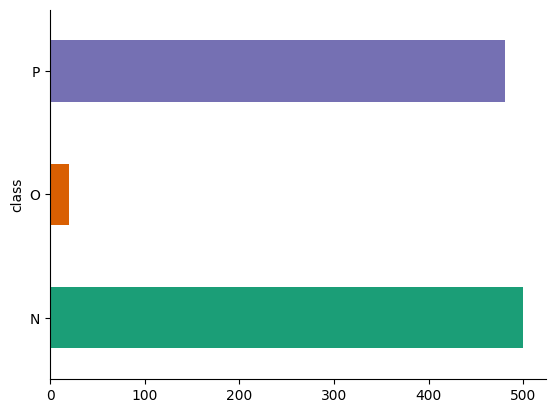

In [74]:
# @title class

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [75]:
data = data.dropna()

In [83]:
data = data[1:]
data.columns = ['Tweet', 'Class']
data = data[data['Class'].isin(['P', 'N'])]

data['Class'] = data['Class'].apply(lambda x: 1 if x == 'P' else 0)

train, test = train_test_split(data, test_size=0.25, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Tweet'])

X_train_sequences = tokenizer.texts_to_sequences(train['Tweet'])
X_test_sequences = tokenizer.texts_to_sequences(test['Tweet'])

max_len = max(max(len(s) for s in X_train_sequences), max(len(s) for s in X_test_sequences))
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len)

y_train = train['Class'].values
y_test = test['Class'].values
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values
train.shape, test.shape, train.head()

((733, 2),
 (245, 2),
                                                  Tweet  Class
 484  دھرنا ختم کرنے پر عوامی تحریک کے کارکنان پھوٹ ...      0
 364              صاف چلی شفاف چلی۔۔۔ تحریکِ انصاف چلی       1
 648  پارلیمنٹ ، صوبائی اسمبلیاں ، وفاقی اور صوبائی ...      0
 647  آپؓ کا اسم گرامی ’’عمر‘‘ لقب ’’فاروق‘‘ اور کنی...      1
 471  : ڈھائی سو ارب روپے سگریٹ میں پھونک دیے ۔۔۔۔جو...      0)

In [85]:

def build_model(model_type, input_length, num_layers, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=input_length))

    for i in range(num_layers):
        if model_type == 'LSTM':
            model.add(LSTM(128, return_sequences=(i < num_layers - 1)))
        elif model_type == 'GRU':
            model.add(GRU(128, return_sequences=(i < num_layers - 1)))
        elif model_type == 'RNN':
            model.add(SimpleRNN(128, return_sequences=(i < num_layers - 1)))
        elif model_type == 'BiLSTM':
            model.add(Bidirectional(LSTM(128, return_sequences=(i < num_layers - 1))))

        model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [86]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f_score = f1_score(y_true, y_pred, average='binary')

    return accuracy, precision, recall, f_score


In [97]:
model_types = ['RNN', 'GRU', 'LSTM', 'BiLSTM']
num_layers_options = [2, 3]
dropout_rates = [0.3, 0.7]

results = []

for model_type in model_types:
    for num_layers in num_layers_options:
        for dropout_rate in dropout_rates:
            model = build_model(model_type, max_len, num_layers, dropout_rate)
            model.fit(X_train_pad, y_train, batch_size=128, epochs=50, validation_data=(X_test_pad, y_test), shuffle=True,)
            model.save(f'{model_type}_{num_layers}_{dropout_rate}.h5')

            accuracy, precision, recall, f_score = evaluate_model(model, X_test_pad, y_test)
            results.append({
                'Model': model_type,
                'Layers': num_layers,
                'Dropout': dropout_rate,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f_score
            })

Epoch 1/50
6/6 [==============================] - 7s 225ms/step - loss: 0.7508 - accuracy: 0.5075 - val_loss: 0.7112 - val_accuracy: 0.4980
Epoch 2/50
6/6 [==============================] - 1s 169ms/step - loss: 0.5824 - accuracy: 0.6808 - val_loss: 0.7393 - val_accuracy: 0.5184
Epoch 3/50
6/6 [==============================] - 1s 192ms/step - loss: 0.3306 - accuracy: 0.8909 - val_loss: 0.9113 - val_accuracy: 0.5265
Epoch 4/50
6/6 [==============================] - 1s 214ms/step - loss: 0.1219 - accuracy: 0.9632 - val_loss: 1.1961 - val_accuracy: 0.5265
Epoch 5/50
6/6 [==============================] - 1s 181ms/step - loss: 0.0418 - accuracy: 0.9877 - val_loss: 1.4706 - val_accuracy: 0.4939
Epoch 6/50
6/6 [==============================] - 1s 163ms/step - loss: 0.0287 - accuracy: 0.9918 - val_loss: 1.6128 - val_accuracy: 0.4980
Epoch 7/50
6/6 [==============================] - 1s 191ms/step - loss: 0.0121 - accuracy: 0.9945 - val_loss: 1.5935 - val_accuracy: 0.5306
Epoch 8/50
6/6 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
Epoch 1/50
6/6 [==============================] - 4s 226ms/step - loss: 0.8940 - accuracy: 0.5020 - val_loss: 0.6909 - val_accuracy: 0.5388
Epoch 2/50
6/6 [==============================] - 1s 243ms/step - loss: 0.7987 - accuracy: 0.5539 - val_loss: 0.6996 - val_accuracy: 0.5469
Epoch 3/50
6/6 [==============================] - 2s 280ms/step - loss: 0.7161 - accuracy: 0.5962 - val_loss: 0.6957 - val_accuracy: 0.5510
Epoch 4/50
6/6 [==============================] - 1s 167ms/step - loss: 0.6135 - accuracy: 0.6480 - val_loss: 0.7179 - val_accuracy: 0.5184
Epoch 5/50
6/6 [==============================] - 1s 185ms/step - loss: 0.4976 - accuracy: 0.7462 - val_loss: 0.7866 - val_accuracy: 0.5143
Epoch 6/50
6/6 [==============================] - 1s 191ms/step - loss: 0.3468 - accuracy: 0.8554 - val_loss: 0.9885 - val_accuracy: 0.5510
Epoch 7/50
6/6 [==============================] - 1s 169ms/step - loss: 0.2214 - accuracy: 0.9086 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 7ms/step
Epoch 1/50
6/6 [==============================] - 5s 312ms/step - loss: 0.8500 - accuracy: 0.5143 - val_loss: 0.7131 - val_accuracy: 0.4939
Epoch 2/50
6/6 [==============================] - 1s 199ms/step - loss: 0.7068 - accuracy: 0.5675 - val_loss: 0.7603 - val_accuracy: 0.5020
Epoch 3/50
6/6 [==============================] - 1s 167ms/step - loss: 0.4621 - accuracy: 0.7640 - val_loss: 0.9385 - val_accuracy: 0.4980
Epoch 4/50
6/6 [==============================] - 1s 178ms/step - loss: 0.2557 - accuracy: 0.8950 - val_loss: 1.2288 - val_accuracy: 0.5102
Epoch 5/50
6/6 [==============================] - 1s 188ms/step - loss: 0.1154 - accuracy: 0.9577 - val_loss: 1.4209 - val_accuracy: 0.5429
Epoch 6/50
6/6 [==============================] - 1s 180ms/step - loss: 0.0349 - accuracy: 0.9905 - val_loss: 1.6495 - val_accuracy: 0.5265
Epoch 7/50
6/6 [==============================] - 1s 201ms/step - loss: 0.0242 - accuracy: 0.9932 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 15ms/step
Epoch 1/50
6/6 [==============================] - 6s 282ms/step - loss: 1.1768 - accuracy: 0.5157 - val_loss: 0.7752 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 201ms/step - loss: 1.1623 - accuracy: 0.4925 - val_loss: 0.7628 - val_accuracy: 0.4694
Epoch 3/50
6/6 [==============================] - 1s 203ms/step - loss: 0.9952 - accuracy: 0.5389 - val_loss: 0.7583 - val_accuracy: 0.5184
Epoch 4/50
6/6 [==============================] - 1s 199ms/step - loss: 1.0448 - accuracy: 0.5252 - val_loss: 0.7170 - val_accuracy: 0.4980
Epoch 5/50
6/6 [==============================] - 1s 204ms/step - loss: 1.0606 - accuracy: 0.5266 - val_loss: 0.7205 - val_accuracy: 0.5102
Epoch 6/50
6/6 [==============================] - 2s 332ms/step - loss: 1.0376 - accuracy: 0.5130 - val_loss: 0.7449 - val_accuracy: 0.4980
Epoch 7/50
6/6 [==============================] - 2s 240ms/step - loss: 0.8936 - accuracy: 0.5457 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 12ms/step
Epoch 1/50
6/6 [==============================] - 6s 268ms/step - loss: 0.6944 - accuracy: 0.4748 - val_loss: 0.6935 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 116ms/step - loss: 0.6858 - accuracy: 0.5539 - val_loss: 0.6974 - val_accuracy: 0.4776
Epoch 3/50
6/6 [==============================] - 1s 116ms/step - loss: 0.6419 - accuracy: 0.6576 - val_loss: 0.6888 - val_accuracy: 0.5510
Epoch 4/50
6/6 [==============================] - 1s 112ms/step - loss: 0.4757 - accuracy: 0.8718 - val_loss: 0.8218 - val_accuracy: 0.5510
Epoch 5/50
6/6 [==============================] - 1s 113ms/step - loss: 0.2129 - accuracy: 0.9222 - val_loss: 0.9345 - val_accuracy: 0.6122
Epoch 6/50
6/6 [==============================] - 1s 96ms/step - loss: 0.0771 - accuracy: 0.9727 - val_loss: 1.1119 - val_accuracy: 0.6204
Epoch 7/50
6/6 [==============================] - 1s 111ms/step - loss: 0.0340 - accuracy: 0.9864 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 4ms/step
Epoch 1/50
6/6 [==============================] - 5s 402ms/step - loss: 0.6927 - accuracy: 0.5239 - val_loss: 0.6939 - val_accuracy: 0.4776
Epoch 2/50
6/6 [==============================] - 1s 135ms/step - loss: 0.6865 - accuracy: 0.5334 - val_loss: 0.6950 - val_accuracy: 0.4816
Epoch 3/50
6/6 [==============================] - 1s 120ms/step - loss: 0.6645 - accuracy: 0.6685 - val_loss: 0.6917 - val_accuracy: 0.5510
Epoch 4/50
6/6 [==============================] - 1s 96ms/step - loss: 0.5913 - accuracy: 0.7804 - val_loss: 0.7466 - val_accuracy: 0.5224
Epoch 5/50
6/6 [==============================] - 1s 122ms/step - loss: 0.3688 - accuracy: 0.8759 - val_loss: 0.7929 - val_accuracy: 0.6041
Epoch 6/50
6/6 [==============================] - 1s 178ms/step - loss: 0.1365 - accuracy: 0.9536 - val_loss: 1.0736 - val_accuracy: 0.6245
Epoch 7/50
6/6 [==============================] - 1s 139ms/step - loss: 0.0492 - accuracy: 0.9809 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 4ms/step
Epoch 1/50
6/6 [==============================] - 7s 311ms/step - loss: 0.6934 - accuracy: 0.5130 - val_loss: 0.6974 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 81ms/step - loss: 0.6823 - accuracy: 0.6194 - val_loss: 0.6935 - val_accuracy: 0.5020
Epoch 3/50
6/6 [==============================] - 1s 133ms/step - loss: 0.6150 - accuracy: 0.7531 - val_loss: 0.7945 - val_accuracy: 0.5306
Epoch 4/50
6/6 [==============================] - 1s 126ms/step - loss: 0.3578 - accuracy: 0.8622 - val_loss: 0.8429 - val_accuracy: 0.5551
Epoch 5/50
6/6 [==============================] - 1s 121ms/step - loss: 0.1440 - accuracy: 0.9536 - val_loss: 1.3802 - val_accuracy: 0.5837
Epoch 6/50
6/6 [==============================] - 1s 121ms/step - loss: 0.0578 - accuracy: 0.9768 - val_loss: 1.4471 - val_accuracy: 0.6082
Epoch 7/50
6/6 [==============================] - 1s 125ms/step - loss: 0.0331 - accuracy: 0.9877 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 5ms/step
Epoch 1/50
6/6 [==============================] - 8s 291ms/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6950 - val_accuracy: 0.4735
Epoch 2/50
6/6 [==============================] - 1s 124ms/step - loss: 0.6890 - accuracy: 0.5471 - val_loss: 0.6949 - val_accuracy: 0.4735
Epoch 3/50
6/6 [==============================] - 1s 121ms/step - loss: 0.6764 - accuracy: 0.6344 - val_loss: 0.6945 - val_accuracy: 0.5469
Epoch 4/50
6/6 [==============================] - 1s 103ms/step - loss: 0.6057 - accuracy: 0.7476 - val_loss: 0.7780 - val_accuracy: 0.5265
Epoch 5/50
6/6 [==============================] - 1s 119ms/step - loss: 0.3485 - accuracy: 0.8690 - val_loss: 0.9209 - val_accuracy: 0.5673
Epoch 6/50
6/6 [==============================] - 1s 117ms/step - loss: 0.1243 - accuracy: 0.9550 - val_loss: 1.4156 - val_accuracy: 0.5755
Epoch 7/50
6/6 [==============================] - 1s 114ms/step - loss: 0.0796 - accuracy: 0.9754 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 5ms/step
Epoch 1/50
6/6 [==============================] - 6s 394ms/step - loss: 0.6937 - accuracy: 0.5130 - val_loss: 0.6939 - val_accuracy: 0.4612
Epoch 2/50
6/6 [==============================] - 1s 99ms/step - loss: 0.6872 - accuracy: 0.5512 - val_loss: 0.6947 - val_accuracy: 0.4612
Epoch 3/50
6/6 [==============================] - 1s 120ms/step - loss: 0.6601 - accuracy: 0.6467 - val_loss: 0.7010 - val_accuracy: 0.5143
Epoch 4/50
6/6 [==============================] - 1s 122ms/step - loss: 0.5551 - accuracy: 0.6917 - val_loss: 0.7168 - val_accuracy: 0.5796
Epoch 5/50
6/6 [==============================] - 1s 117ms/step - loss: 0.3216 - accuracy: 0.8990 - val_loss: 0.7763 - val_accuracy: 0.5755
Epoch 6/50
6/6 [==============================] - 1s 78ms/step - loss: 0.1492 - accuracy: 0.9591 - val_loss: 0.9670 - val_accuracy: 0.6286
Epoch 7/50
6/6 [==============================] - 1s 122ms/step - loss: 0.0591 - accuracy: 0.9809 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 5ms/step
Epoch 1/50
6/6 [==============================] - 6s 447ms/step - loss: 0.6940 - accuracy: 0.5034 - val_loss: 0.6943 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 108ms/step - loss: 0.6896 - accuracy: 0.5362 - val_loss: 0.6944 - val_accuracy: 0.4816
Epoch 3/50
6/6 [==============================] - 1s 104ms/step - loss: 0.6799 - accuracy: 0.6030 - val_loss: 0.6956 - val_accuracy: 0.4898
Epoch 4/50
6/6 [==============================] - 1s 123ms/step - loss: 0.6207 - accuracy: 0.6712 - val_loss: 0.7275 - val_accuracy: 0.5592
Epoch 5/50
6/6 [==============================] - 1s 122ms/step - loss: 0.4184 - accuracy: 0.8445 - val_loss: 0.8875 - val_accuracy: 0.5306
Epoch 6/50
6/6 [==============================] - 1s 81ms/step - loss: 0.2594 - accuracy: 0.8909 - val_loss: 0.7930 - val_accuracy: 0.5592
Epoch 7/50
6/6 [==============================] - 1s 114ms/step - loss: 0.1480 - accuracy: 0.9618 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 4ms/step
Epoch 1/50
6/6 [==============================] - 7s 326ms/step - loss: 0.6937 - accuracy: 0.5130 - val_loss: 0.6942 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 100ms/step - loss: 0.6901 - accuracy: 0.5252 - val_loss: 0.6960 - val_accuracy: 0.4857
Epoch 3/50
6/6 [==============================] - 1s 120ms/step - loss: 0.6773 - accuracy: 0.6044 - val_loss: 0.6990 - val_accuracy: 0.4939
Epoch 4/50
6/6 [==============================] - 1s 103ms/step - loss: 0.5981 - accuracy: 0.6603 - val_loss: 0.7191 - val_accuracy: 0.5755
Epoch 5/50
6/6 [==============================] - 1s 99ms/step - loss: 0.3247 - accuracy: 0.8840 - val_loss: 0.9770 - val_accuracy: 0.5755
Epoch 6/50
6/6 [==============================] - 1s 84ms/step - loss: 0.1597 - accuracy: 0.9454 - val_loss: 0.9845 - val_accuracy: 0.5959
Epoch 7/50
6/6 [==============================] - 1s 122ms/step - loss: 0.0940 - accuracy: 0.9604 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 5ms/step
Epoch 1/50
6/6 [==============================] - 8s 346ms/step - loss: 0.6924 - accuracy: 0.5061 - val_loss: 0.6942 - val_accuracy: 0.4776
Epoch 2/50
6/6 [==============================] - 1s 105ms/step - loss: 0.6913 - accuracy: 0.5334 - val_loss: 0.6968 - val_accuracy: 0.4816
Epoch 3/50
6/6 [==============================] - 1s 103ms/step - loss: 0.6899 - accuracy: 0.5348 - val_loss: 0.6955 - val_accuracy: 0.4735
Epoch 4/50
6/6 [==============================] - 1s 127ms/step - loss: 0.6797 - accuracy: 0.5744 - val_loss: 0.7032 - val_accuracy: 0.4939
Epoch 5/50
6/6 [==============================] - 1s 83ms/step - loss: 0.6230 - accuracy: 0.6698 - val_loss: 0.7234 - val_accuracy: 0.5143
Epoch 6/50
6/6 [==============================] - 1s 84ms/step - loss: 0.4124 - accuracy: 0.8186 - val_loss: 1.0571 - val_accuracy: 0.5592
Epoch 7/50
6/6 [==============================] - 1s 103ms/step - loss: 0.2289 - accuracy: 0.9018 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 5ms/step
Epoch 1/50
6/6 [==============================] - 9s 370ms/step - loss: 0.6948 - accuracy: 0.4611 - val_loss: 0.6980 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 138ms/step - loss: 0.6844 - accuracy: 0.5443 - val_loss: 0.6945 - val_accuracy: 0.4735
Epoch 3/50
6/6 [==============================] - 1s 125ms/step - loss: 0.6343 - accuracy: 0.6999 - val_loss: 0.7439 - val_accuracy: 0.5020
Epoch 4/50
6/6 [==============================] - 1s 90ms/step - loss: 0.3818 - accuracy: 0.8267 - val_loss: 1.1118 - val_accuracy: 0.5592
Epoch 5/50
6/6 [==============================] - 1s 113ms/step - loss: 0.1385 - accuracy: 0.9604 - val_loss: 1.5679 - val_accuracy: 0.5796
Epoch 6/50
6/6 [==============================] - 1s 96ms/step - loss: 0.0574 - accuracy: 0.9836 - val_loss: 1.0713 - val_accuracy: 0.5837
Epoch 7/50
6/6 [==============================] - 1s 142ms/step - loss: 0.0264 - accuracy: 0.9945 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 2s 7ms/step
Epoch 1/50
6/6 [==============================] - 9s 400ms/step - loss: 0.6928 - accuracy: 0.5252 - val_loss: 0.6960 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 135ms/step - loss: 0.6916 - accuracy: 0.5225 - val_loss: 0.6941 - val_accuracy: 0.4735
Epoch 3/50
6/6 [==============================] - 1s 107ms/step - loss: 0.6878 - accuracy: 0.5430 - val_loss: 0.6970 - val_accuracy: 0.4857
Epoch 4/50
6/6 [==============================] - 1s 106ms/step - loss: 0.6605 - accuracy: 0.6371 - val_loss: 0.6963 - val_accuracy: 0.5429
Epoch 5/50
6/6 [==============================] - 1s 115ms/step - loss: 0.5648 - accuracy: 0.7203 - val_loss: 0.7062 - val_accuracy: 0.5837
Epoch 6/50
6/6 [==============================] - 1s 111ms/step - loss: 0.2366 - accuracy: 0.9318 - val_loss: 1.5759 - val_accuracy: 0.6041
Epoch 7/50
6/6 [==============================] - 1s 130ms/step - loss: 0.0836 - accuracy: 0.9782 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 6ms/step
Epoch 1/50
6/6 [==============================] - 13s 503ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6970 - val_accuracy: 0.4816
Epoch 2/50
6/6 [==============================] - 1s 215ms/step - loss: 0.6865 - accuracy: 0.5321 - val_loss: 0.6946 - val_accuracy: 0.5143
Epoch 3/50
6/6 [==============================] - 1s 190ms/step - loss: 0.6362 - accuracy: 0.6548 - val_loss: 0.7645 - val_accuracy: 0.4816
Epoch 4/50
6/6 [==============================] - 1s 136ms/step - loss: 0.3913 - accuracy: 0.7817 - val_loss: 1.6179 - val_accuracy: 0.6082
Epoch 5/50
6/6 [==============================] - 1s 122ms/step - loss: 0.1312 - accuracy: 0.9577 - val_loss: 1.4185 - val_accuracy: 0.6408
Epoch 6/50
6/6 [==============================] - 1s 117ms/step - loss: 0.0674 - accuracy: 0.9864 - val_loss: 1.4721 - val_accuracy: 0.6041
Epoch 7/50
6/6 [==============================] - 1s 119ms/step - loss: 0.0435 - accuracy: 0.9905 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 2s 10ms/step
Epoch 1/50
6/6 [==============================] - 12s 527ms/step - loss: 0.6948 - accuracy: 0.4993 - val_loss: 0.6936 - val_accuracy: 0.4898
Epoch 2/50
6/6 [==============================] - 1s 139ms/step - loss: 0.6887 - accuracy: 0.5553 - val_loss: 0.6942 - val_accuracy: 0.4980
Epoch 3/50
6/6 [==============================] - 1s 136ms/step - loss: 0.6801 - accuracy: 0.5784 - val_loss: 0.6996 - val_accuracy: 0.4816
Epoch 4/50
6/6 [==============================] - 1s 117ms/step - loss: 0.6138 - accuracy: 0.6698 - val_loss: 0.7678 - val_accuracy: 0.5306
Epoch 5/50
6/6 [==============================] - 1s 166ms/step - loss: 0.2928 - accuracy: 0.8840 - val_loss: 1.6243 - val_accuracy: 0.6000
Epoch 6/50
6/6 [==============================] - 1s 198ms/step - loss: 0.1197 - accuracy: 0.9659 - val_loss: 1.1831 - val_accuracy: 0.5796
Epoch 7/50
6/6 [==============================] - 1s 155ms/step - loss: 0.0656 - accuracy: 0.9836 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 3s 10ms/step


In [100]:
res= pd.DataFrame(results)

In [101]:
res

,Model,Layers,Dropout,Accuracy,Precision,Recall,F1 Score
0,RNN,2,0.3,0.567347,0.580153,0.598425,0.589147
1,RNN,2,0.7,0.571429,0.587302,0.582677,0.584980
2,RNN,3,0.3,0.551020,0.562044,0.606299,0.583333
3,RNN,3,0.7,0.538776,0.563636,0.488189,0.523207
4,GRU,2,0.3,0.640816,0.661157,0.629921,0.645161
5,GRU,2,0.7,0.620408,0.644068,0.598425,0.620408
6,GRU,3,0.3,0.624490,0.629630,0.669291,0.648855
7,GRU,3,0.7,0.583673,0.591241,0.637795,0.613636
8,LSTM,2,0.3,0.604082,0.631579,0.566929,0.597510
9,LSTM,2,0.7,0.571429,0.582090,0.614173,0.597701


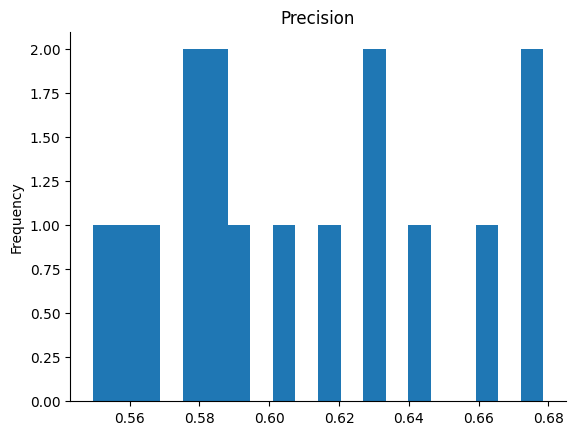

In [103]:
# @title Precision

from matplotlib import pyplot as plt
res['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

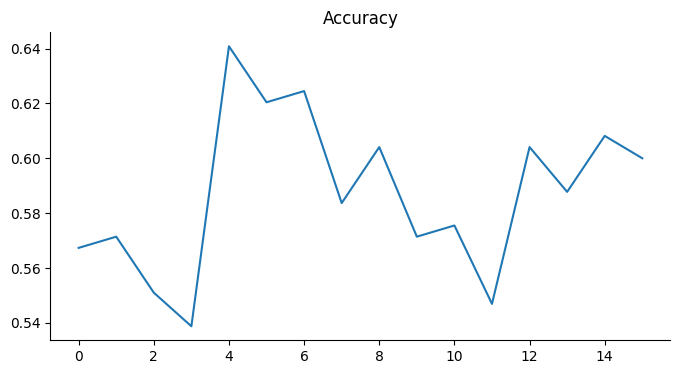

In [102]:
# @title Accuracy

from matplotlib import pyplot as plt
res['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)